# DCGAN

- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks(https://arxiv.org/pdf/1511.06434.pdf)

![alt text](./dcgan.png)

## 1. Import required libraries

In [1]:
# Vanilla GAN with Multi GPUs + Naming Layers using OrderedDict
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter setting

In [2]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1

## 3. Data Setting

In [3]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

In [4]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*256),
             nn.BatchNorm1d(7*7*256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)),
                        ('bn1', nn.BatchNorm2d(128)),
                        ('relu1', nn.LeakyReLU()),
                        ('conv2', nn.ConvTranspose2d(128,64,3,1,1)),
                        ('bn2', nn.BatchNorm2d(64)),    
                        ('relu2', nn.LeakyReLU()),
            ]))
        self.layer3 = nn.Sequential(OrderedDict([
                        ('conv3',nn.ConvTranspose2d(64,16,3,1,1)),
                        ('bn3',nn.BatchNorm2d(16)),    
                        ('relu3',nn.LeakyReLU()),
                        ('conv4',nn.ConvTranspose2d(16,1,3,2,1,1)),
                        ('relu4',nn.Tanh())
            ]))

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size//num_gpus,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

## 5. Discriminator

In [5]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(1,8,3,padding=1)),   # batch x 16 x 28 x 28
                        #('bn1',nn.BatchNorm2d(8)),    
                        ('relu1',nn.LeakyReLU()),
                        ('conv2',nn.Conv2d(8,16,3,padding=1)),  # batch x 32 x 28 x 28
                        ('bn2',nn.BatchNorm2d(16)),    
                        ('relu2',nn.LeakyReLU()),
                        ('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3',nn.Conv2d(16,32,3,padding=1)),  # batch x 64 x 14 x 14
                        ('bn3',nn.BatchNorm2d(32)),
                        ('relu3',nn.LeakyReLU()),
                        ('max2',nn.MaxPool2d(2,2)),
                        ('conv4',nn.Conv2d(32,64,3,padding=1)),  # batch x 128 x 7 x 7
                        ('bn4',nn.BatchNorm2d(64)),
                        ('relu4',nn.LeakyReLU())
        ]))
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size//num_gpus, -1)
        out = self.fc(out)
        return out

## 6. Put instances on Multi-gpu

In [6]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

## 7. Check layers

In [7]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.conv4.weight
module.layer3.conv4.bias


## 8. Set Loss function & Optimizer

In [8]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## 9. Restore Model

In [ ]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 10. Train Model

/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


Variable containing:
 0.2157
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.5549
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 0.2157
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.5549
[torch.cuda.FloatTensor of size 1 (GPU 0)]



/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/gunho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Variable containing:
 0.5568
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1636
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 0.5568
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1636
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7395
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  4.1433
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0th iteration gen_loss: 
 0.7395
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  4.1433
[torch.cuda.FloatTensor of size 1 (GPU 0)]



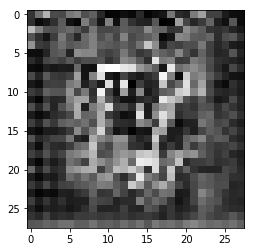

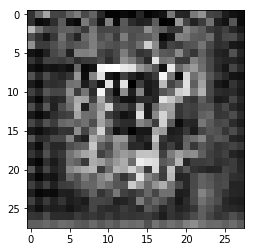

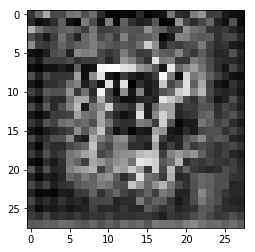

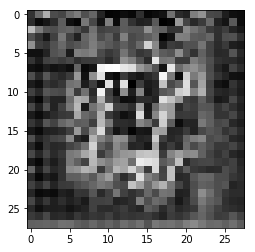

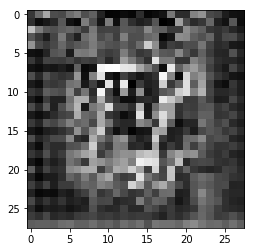

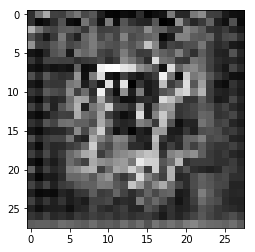

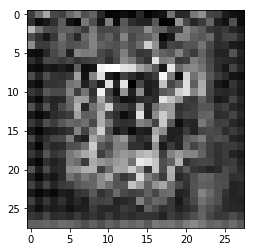

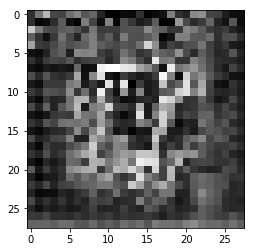

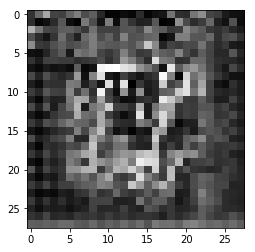

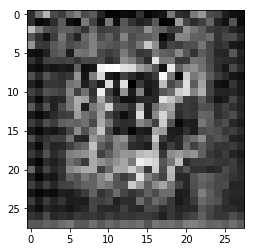

Variable containing:
 0.7948
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  2.7609
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 0.7948
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  2.7609
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6836
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1019
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 0.6836
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1019
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6314
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1524
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1th iteration gen_loss: 
 0.6314
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1524
[torch.cuda.FloatTensor of size 1 (GPU 0)]



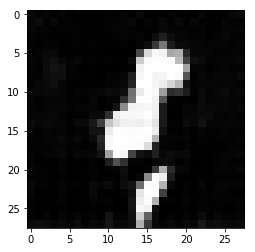

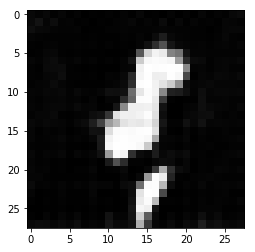

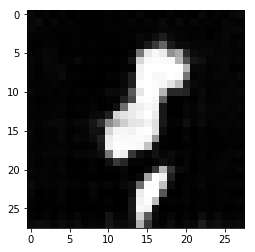

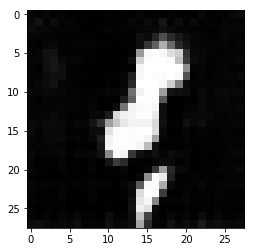

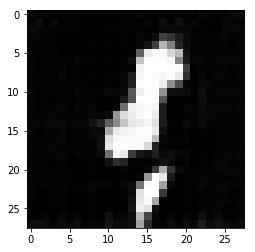

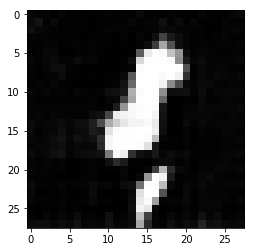

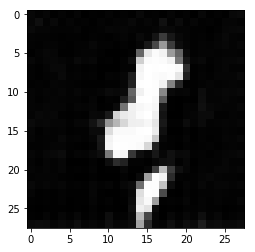

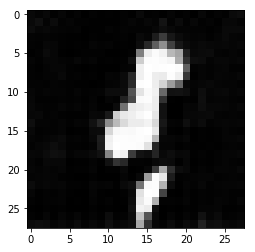

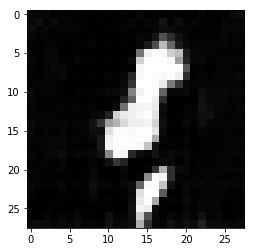

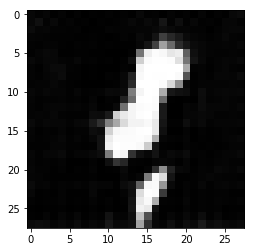

Variable containing:
 0.5618
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2606
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 0.5618
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2606
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7817
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  4.2619
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 0.7817
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  4.2619
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5539
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.6373
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2th iteration gen_loss: 
 0.5539
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.6373
[torch.cuda.FloatTensor of size 1 (GPU 0)]



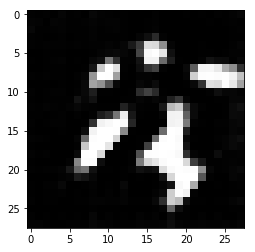

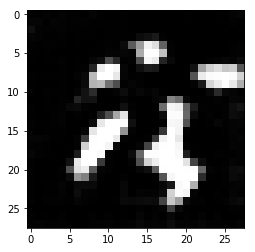

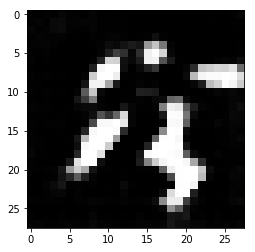

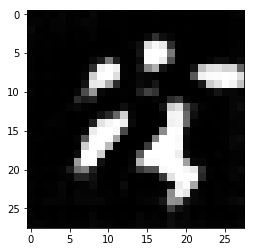

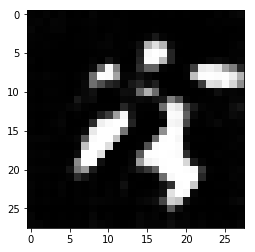

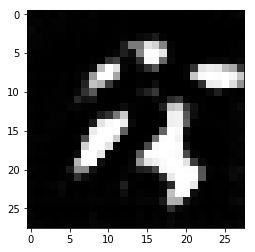

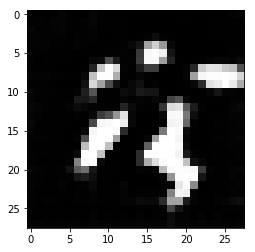

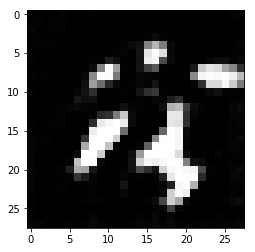

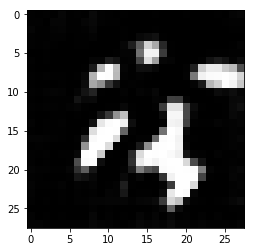

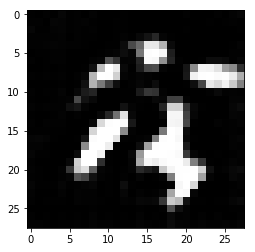

Variable containing:
 0.6628
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3837
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 0.6628
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3837
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5252
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3041
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 0.5252
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3041
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5106
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3513
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3th iteration gen_loss: 
 0.5106
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3513
[torch.cuda.FloatTensor of size 1 (GPU 0)]



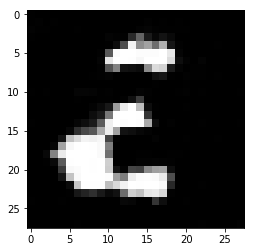

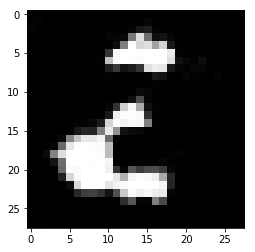

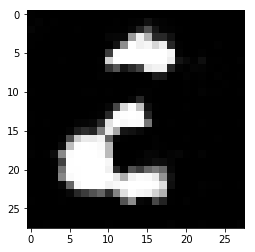

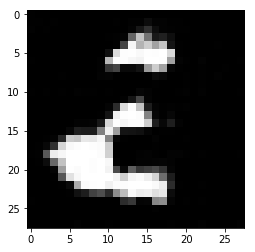

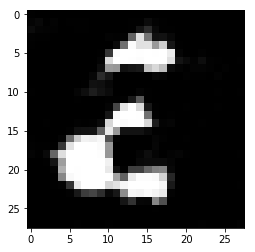

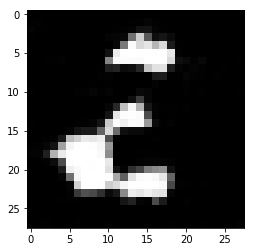

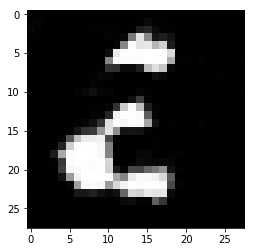

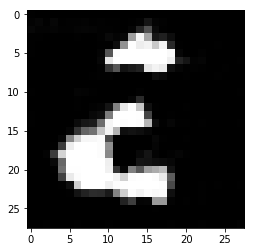

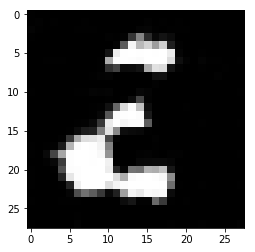

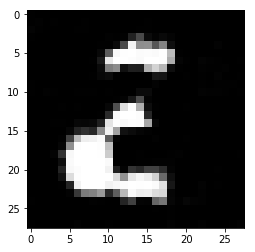

Variable containing:
 0.6171
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2556
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 0.6171
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2556
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5995
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3557
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 0.5995
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3557
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5243
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2325
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4th iteration gen_loss: 
 0.5243
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2325
[torch.cuda.FloatTensor of size 1 (GPU 0)]



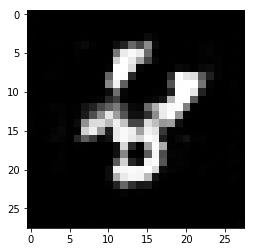

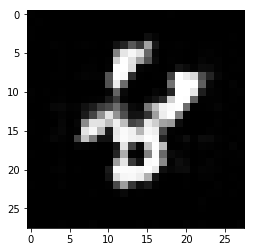

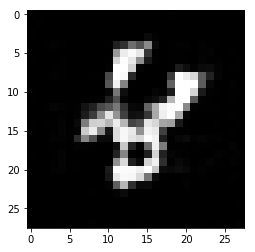

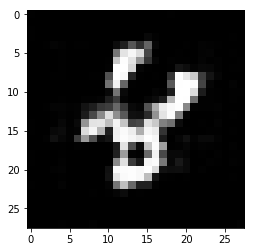

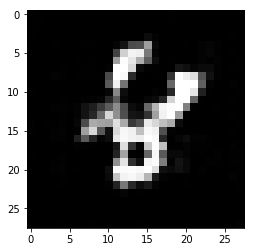

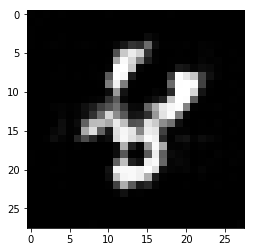

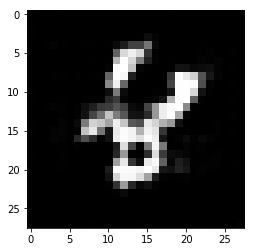

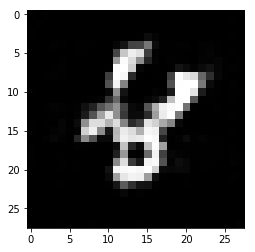

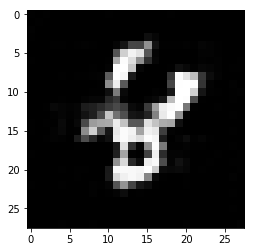

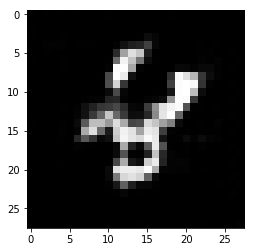

Variable containing:
 0.6770
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2780
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 0.6770
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2780
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6031
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2010
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 0.6031
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2010
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5611
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2789
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5th iteration gen_loss: 
 0.5611
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2789
[torch.cuda.FloatTensor of size 1 (GPU 0)]



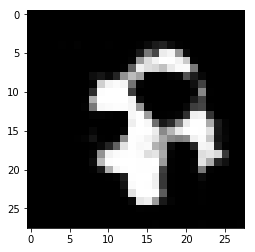

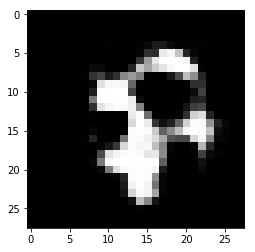

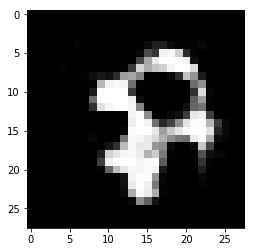

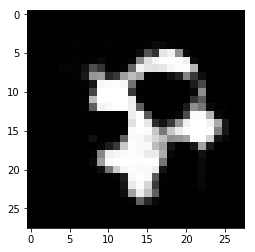

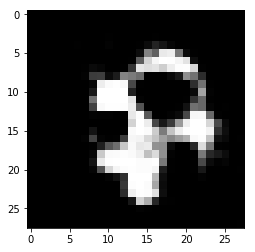

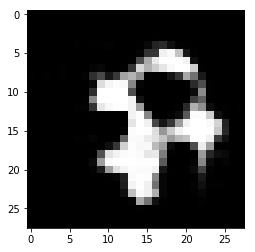

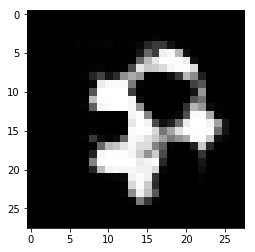

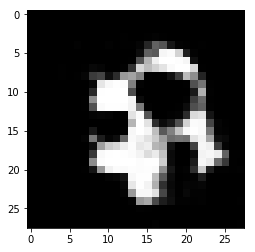

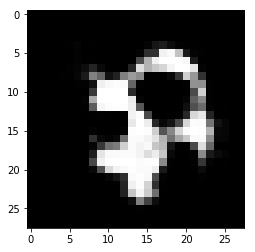

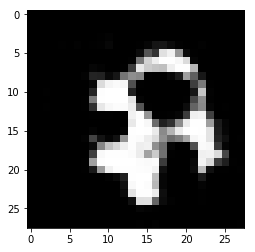

Variable containing:
 0.6268
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1944
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 0.6268
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1944
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7119
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2211
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 0.7119
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2211
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5551
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2398
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6th iteration gen_loss: 
 0.5551
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2398
[torch.cuda.FloatTensor of size 1 (GPU 0)]



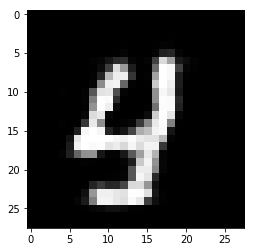

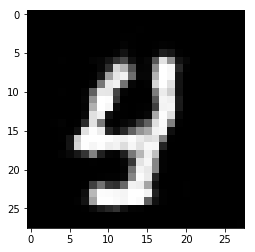

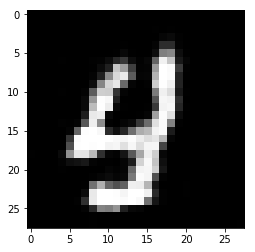

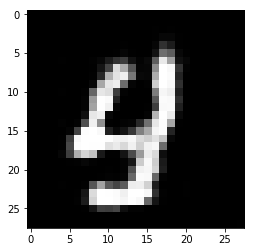

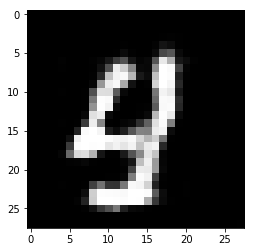

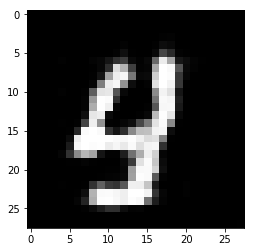

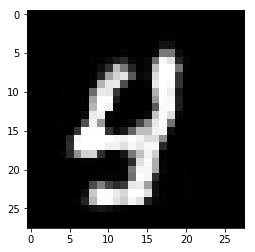

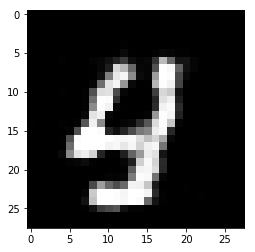

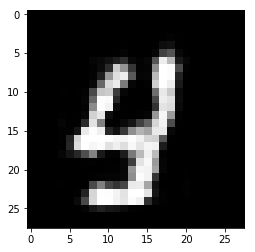

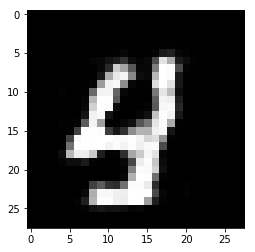

Variable containing:
 0.6843
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3926
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 0.6843
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3926
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7029
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2285
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 0.7029
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2285
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7786
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2352
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7th iteration gen_loss: 
 0.7786
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2352
[torch.cuda.FloatTensor of size 1 (GPU 0)]



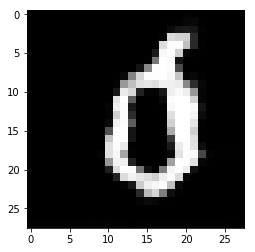

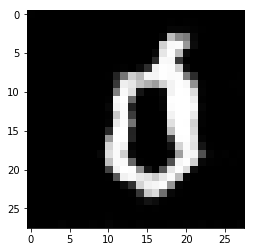

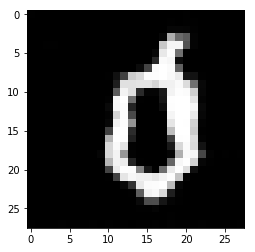

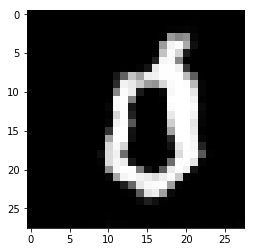

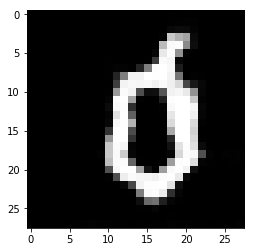

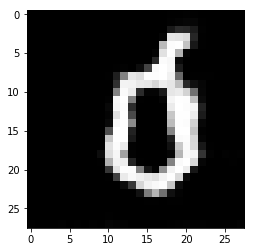

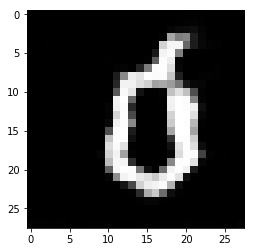

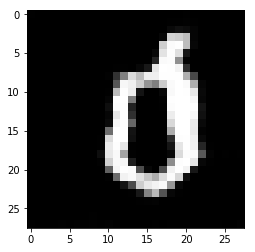

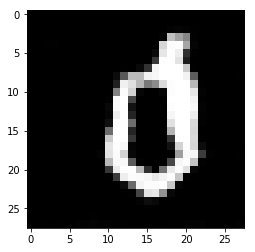

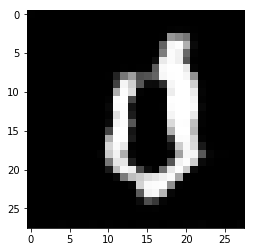

Variable containing:
 0.5117
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2425
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 0.5117
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2425
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7369
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  8.1479
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 0.7369
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  8.1479
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6995
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1417
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8th iteration gen_loss: 
 0.6995
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1417
[torch.cuda.FloatTensor of size 1 (GPU 0)]



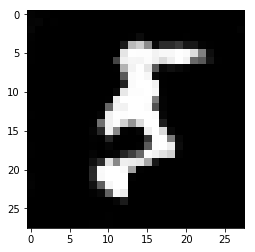

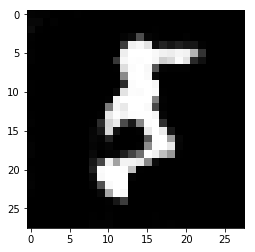

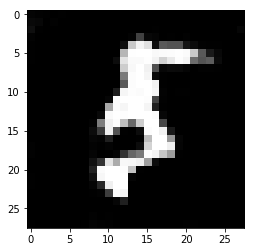

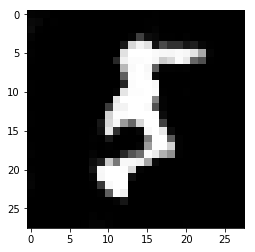

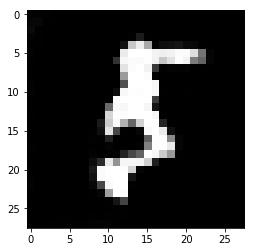

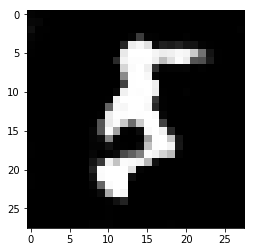

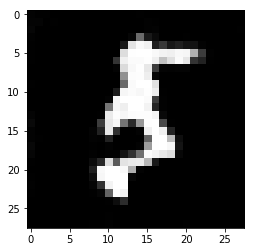

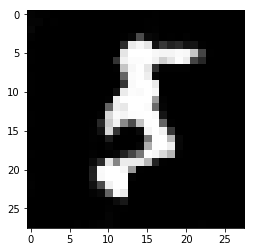

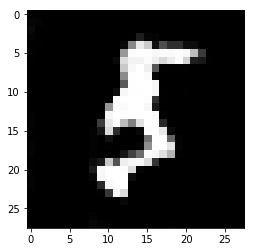

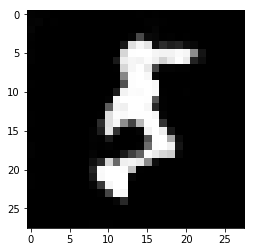

Variable containing:
 0.7410
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1621
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 0.7410
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1621
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6568
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2385
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 0.6568
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2385
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6699
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2483
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9th iteration gen_loss: 
 0.6699
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2483
[torch.cuda.FloatTensor of size 1 (GPU 0)]



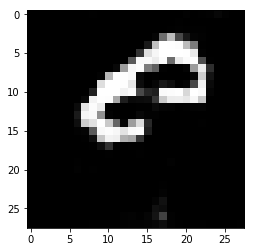

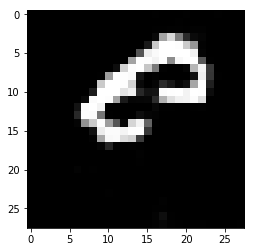

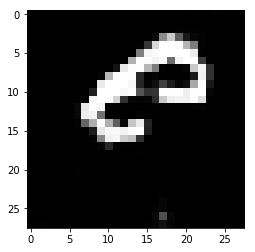

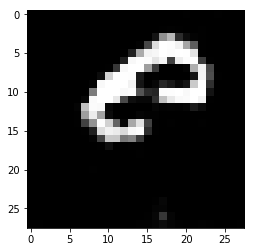

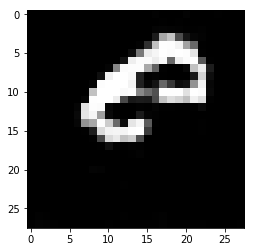

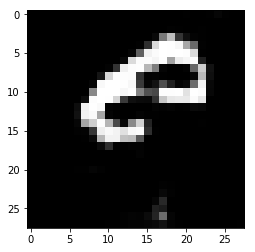

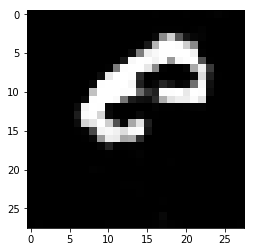

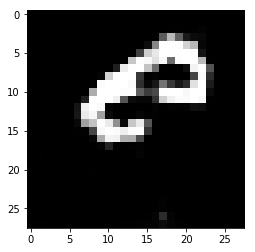

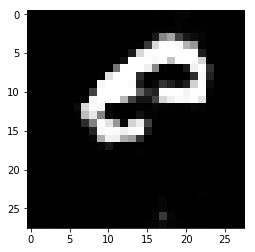

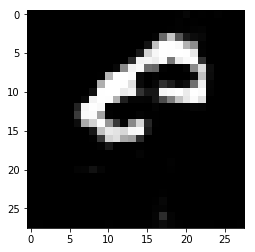

Variable containing:
 0.7133
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  5.7309
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 0.7133
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  5.7309
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6508
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1851
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 0.6508
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1851
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7443
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1168
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10th iteration gen_loss: 
 0.7443
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1168
[torch.cuda.FloatTensor of size 1 (GPU 0)]



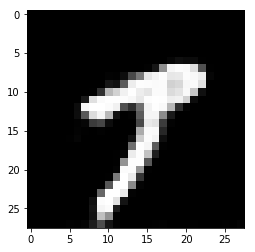

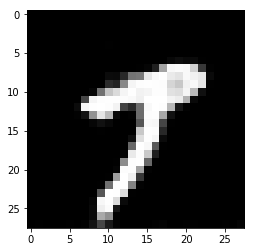

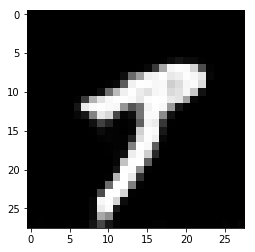

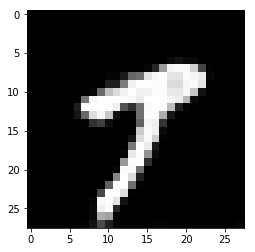

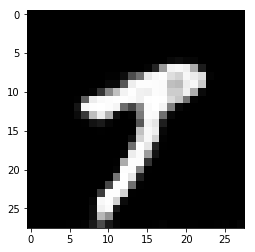

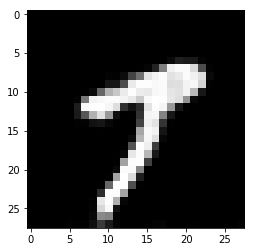

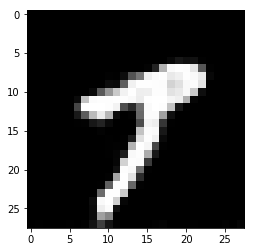

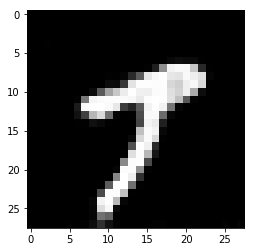

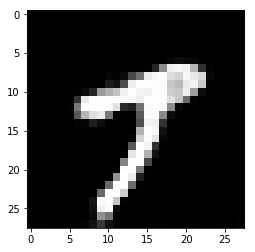

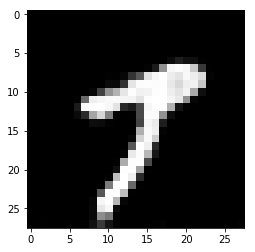

Variable containing:
 0.6949
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1208
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 0.6949
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1208
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7328
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  8.0829
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 0.7328
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  8.0829
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7105
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1028
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11th iteration gen_loss: 
 0.7105
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1028
[torch.cuda.FloatTensor of size 1 (GPU 0)]



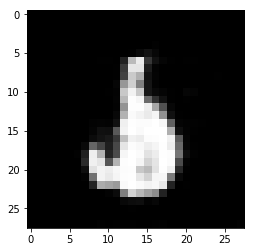

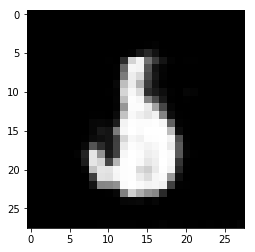

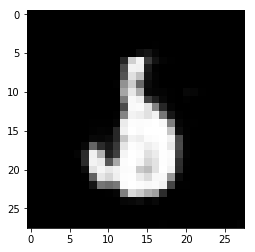

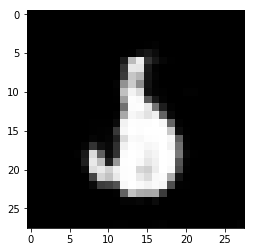

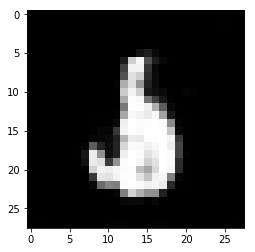

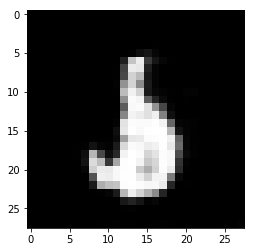

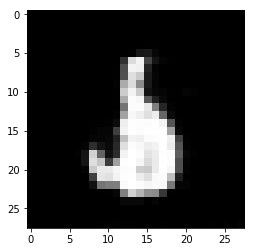

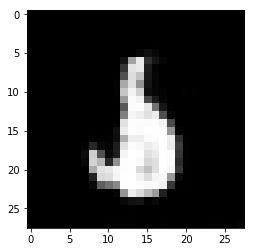

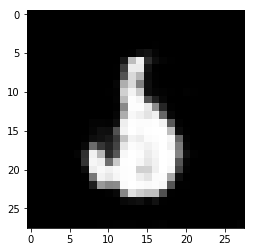

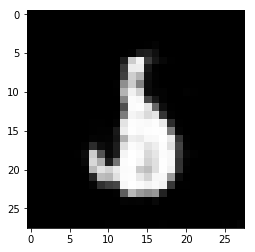

Variable containing:
 0.5471
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.3384
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 0.5471
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.3384
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.5900
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.5208
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 0.5900
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.5208
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6535
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.2532
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12th iteration gen_loss: 
 0.6535
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.2532
[torch.cuda.FloatTensor of size 1 (GPU 0)]



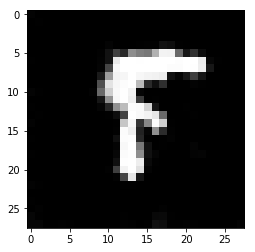

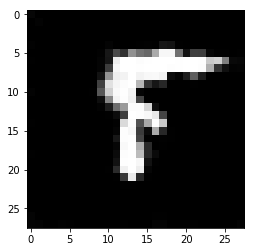

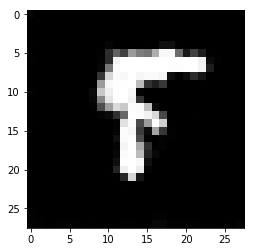

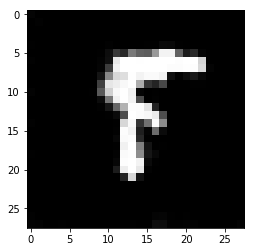

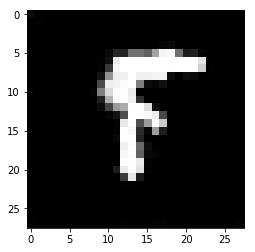

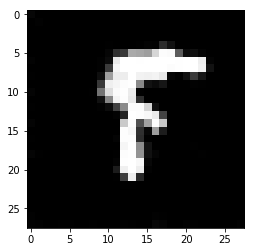

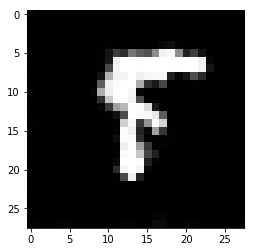

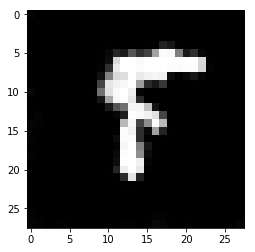

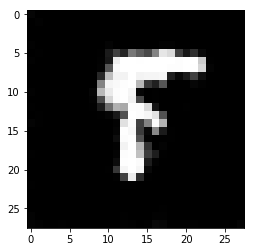

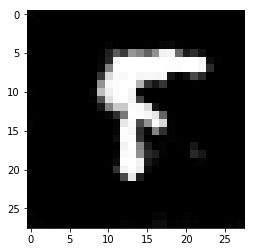

Variable containing:
 0.7487
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1330
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 0.7487
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1330
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6969
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1249
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 0.6969
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1249
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.8440
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
1.00000e-02 *
  7.3127
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13th iteration gen_loss: 
 0.8440
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
1.00000e-02 *
  7.3127
[torch.cuda.FloatTensor of size 1 (GPU 0)]



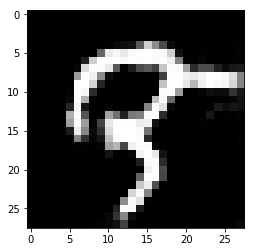

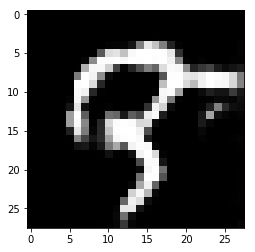

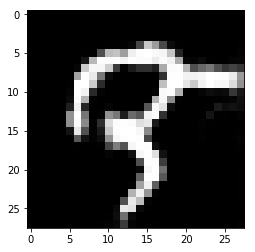

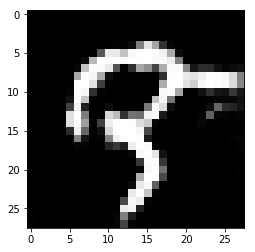

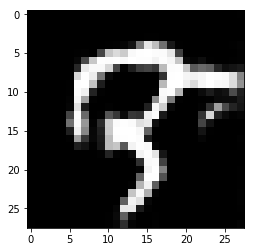

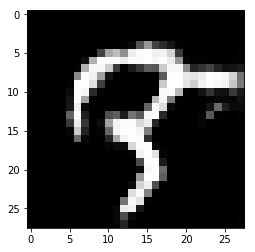

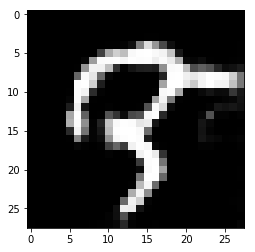

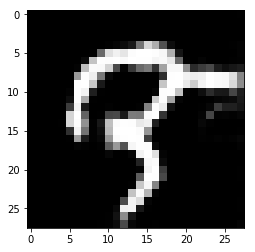

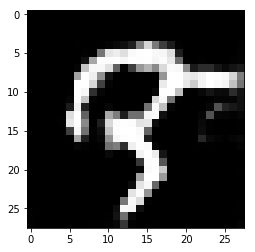

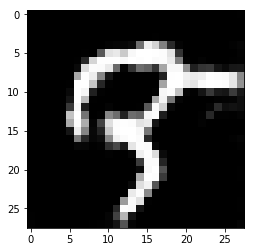

Variable containing:
 0.7306
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1601
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 0.7306
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1601
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.7449
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 0.1902
[torch.cuda.FloatTensor of size 1 (GPU 0)]

14th iteration gen_loss: 
 0.7449
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 dis_loss: 
 0.1902
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [ ]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_variables=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            print(gen_loss,dis_loss)
            torch.save([generator,discriminator],'./model/dcgan.pkl')

            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())